# Roundtrip transfomation
A time-domain signal --> wavelet-domain signal --> time-domain signal

In [2]:
from scipy.signal.windows import tukey
import matplotlib.pyplot as plt
from scipy.signal import chirp, spectrogram
from pywavelet.plotting import plot_wavelet_domain_grid


def waveform_fft(
    t,
    waveform,
):
    N = len(waveform)
    taper = tukey(N, 0.1)
    waveform_w_pad = __zero_pad(waveform * taper)
    waveform_f = np.fft.rfft(waveform_w_pad)[1:]
    n_t = len(__zero_pad(t))
    delta_t = t[1] - t[0]
    freq = np.fft.rfftfreq(n_t, delta_t)[1:]
    return freq, waveform_f


def __zero_pad(data):
    N = len(data)
    pow_2 = np.ceil(np.log2(N))
    return np.pad(data, (0, int((2**pow_2) - N)), "constant")


# plot signal
def plot_time_domain_signal(t, h, freq_range):
    T = max(t)
    fs = 1 / (t[1] - t[0])
    ff, tt, Sxx = spectrogram(h, fs=fs, nperseg=256, nfft=576)
    freq, h_freq = waveform_fft(t, h)

    fig, axes = plt.subplots(3, 1, figsize=(4, 6))
    axes[0].plot(t, h, lw=0.1)
    axes[0].set_ylabel("h(t)")
    axes[0].set_xlim(0, T)
    axes[1].plot(freq, np.abs(h_freq))
    axes[1].set_ylabel("|h(f)|")
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_xlim(*freq_range)
    axes[2].set_xlim(0, T)
    axes[2].pcolormesh(tt, ff, Sxx)
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylabel("Frequency (Hz)")
    axes[2].set_xlim(0, T)
    axes[2].set_ylim(*freq_range)
    # add colorbar to the last axis
    cbar = plt.colorbar(axes[2].collections[0], ax=axes[2])
    cbar.set_label("Amplitude")
    plt.tight_layout()
    return fig


def plot_residuals(residuals):
    fig = plt.figure()
    plt.hist(residuals, bins=100)
    plt.xlabel("Residuals")
    plt.ylabel("Count")
    return fig


def generate_chirp_time_domain_signal(t, freq_range):
    return chirp(
        t, f0=freq_range[0], f1=freq_range[1], t1=t[-1], method="quadratic"
    )

First we set up some constants

In [10]:
import numpy as np

dt = 1 / 512
Nt = 2**6
Nf = 2**6
mult = 16

freq_range = (10, 0.2 * (1 / dt))

ND = Nt * Nf

# time and frequency grids
ts = np.arange(0, ND) * dt
Tobs = max(ts)
fs = np.arange(0, ND // 2 + 1) * 1 / (Tobs)

Let's generate the time-domain signal

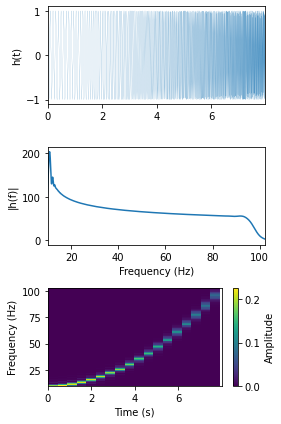

In [11]:
h_time = generate_chirp_time_domain_signal(ts, freq_range)
fig = plot_time_domain_signal(ts, h_time, freq_range)

Convert it to wavelet-domain

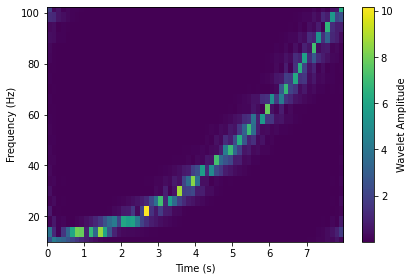

In [12]:
from pywavelet.transforms import from_time_to_wavelet

h_wavelet = from_time_to_wavelet(h_time, Nf=Nf, Nt=Nt, mult=mult)
fig = plot_wavelet_domain_grid(h_wavelet, Nt=Nt, Nf=Nf, cmap="viridis")

Convert it back to time-domain

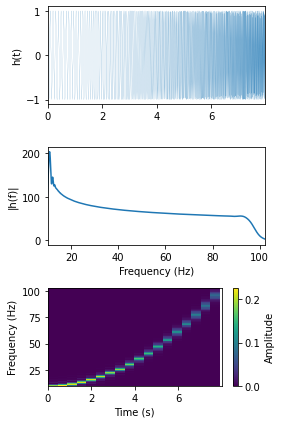

In [6]:
from pywavelet.transforms import from_wavelet_to_time

h_reconstructed = from_wavelet_to_time(h_wavelet, Nf=Nf, Nt=Nt, mult=mult)
fig = plot_time_domain_signal(ts, h_reconstructed, freq_range)

And compute the residuals from the original and reconstructed waveform

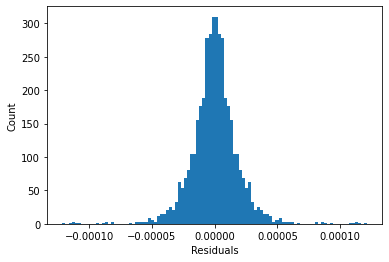

In [7]:
fig = plot_residuals(h_time - h_reconstructed)

In [8]:
if np.allclose(h_time, h_reconstructed, atol=1e-3):
    print("The reconstructed and original waveforms are the same up-to |1e-3|")

The reconstructed and original waveforms are the same up-to |1e-3|
